In [1]:
# Loading the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import os
import cv2
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator



In [2]:
def load_images(path):

    X = []
    y = []

    for folder in os.listdir(path):
        files = os.listdir(path + folder)
        for file in tqdm(files):
            img = cv2.imread(path + folder + '/' + file)
            img = cv2.resize(img, (150, 150))
            X.append(img)
            y.append(folder)
    
    X = np.array(X)
    y = np.array(y)

    return X, y

train_path = '../data/seg_train/'
test_path = '../data/seg_test/'

X_train, y_train = load_images(train_path)
X_test, y_test = load_images(test_path)

classes_names = np.unique(y_train)

# Encoding the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One hot encoding the target variable
y_train_encoded = to_categorical(y_train_encoded)
y_test_encoded = to_categorical(y_test_encoded)

# Splitting the training set into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_encoded, test_size=0.2, random_state=0)

# Normalizing the images
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

  0%|          | 0/2191 [00:00<?, ?it/s]

100%|██████████| 501/501 [00:04<00:00, 107.81it/s]


In [3]:
# Data Augmentation
dataGenerator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'    
)

dataGenerator.fit(X_train)

### ImageDataGenerator é usado para aumentar o conjunto de dados de treinamento, aplicando transformações aleatórias. Isso ajuda a melhorar a generalização do modelo.

- rotation_range: grau de rotação aleatória
- width_shift e height_shift: fração do total de pixels para deslocar
- shear_range: ângulo em sentido horário para cortar
- zoom_range: faixa para zoom aleatório
- horizontal_flip: inverte aleatoriamente metade das imagens horizontalmente
- fill_mode: estratégia para preencher pixels recém-criados, neareast é usado para preencher com o valor mais próximo

In [4]:
# Building the CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [5]:
# Training the model

history = model.fit(dataGenerator.flow(X_train, y_train, batch_size=32), validation_data=(X_val, y_val), epochs=50)

Epoch 1/50
351/351 [==============================] - 159s 448ms/step - loss: 1.2608 - accuracy: 0.4949 - val_loss: 0.9661 - val_accuracy: 0.6427
Epoch 2/50
351/351 [==============================] - 152s 432ms/step - loss: 1.0018 - accuracy: 0.6227 - val_loss: 0.7708 - val_accuracy: 0.7218
Epoch 3/50
351/351 [==============================] - 142s 403ms/step - loss: 0.8859 - accuracy: 0.6717 - val_loss: 0.6991 - val_accuracy: 0.7485
Epoch 4/50
351/351 [==============================] - 137s 389ms/step - loss: 0.8185 - accuracy: 0.6977 - val_loss: 0.6840 - val_accuracy: 0.7510
Epoch 5/50
351/351 [==============================] - 130s 370ms/step - loss: 0.7836 - accuracy: 0.7165 - val_loss: 0.6477 - val_accuracy: 0.7727
Epoch 6/50
351/351 [==============================] - 140s 400ms/step - loss: 0.7315 - accuracy: 0.7402 - val_loss: 0.6215 - val_accuracy: 0.7838
Epoch 7/50
351/351 [==============================] - 137s 389ms/step - loss: 0.6961 - accuracy: 0.7528 - val_loss: 0.5427 -

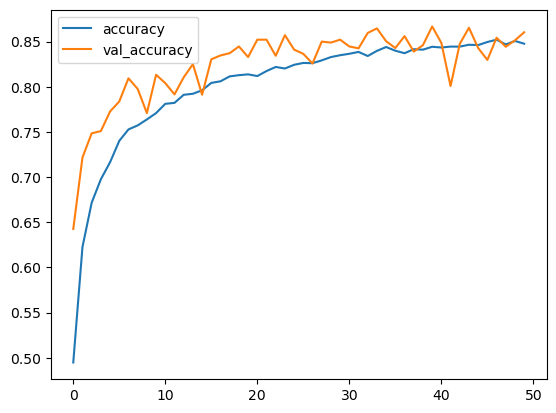

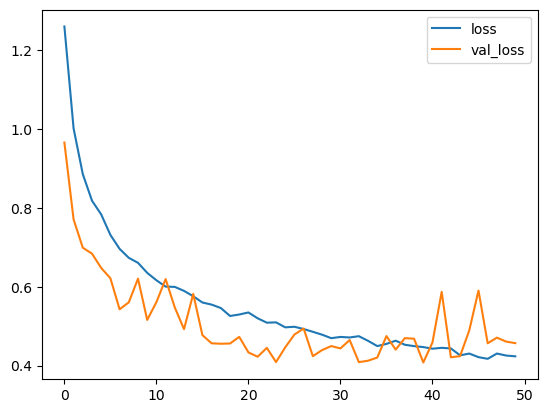

In [6]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


94/94 [==============================] - 7s 73ms/step - loss: 0.4261 - accuracy: 0.8593
F1 Score:  0.860091242203592
Precision:  0.8640984079772703
Recall:  0.8593333333333333
Accuracy:  0.8593333333333333
Loss:  0.4260534644126892
Test Set Evaluation Metrics


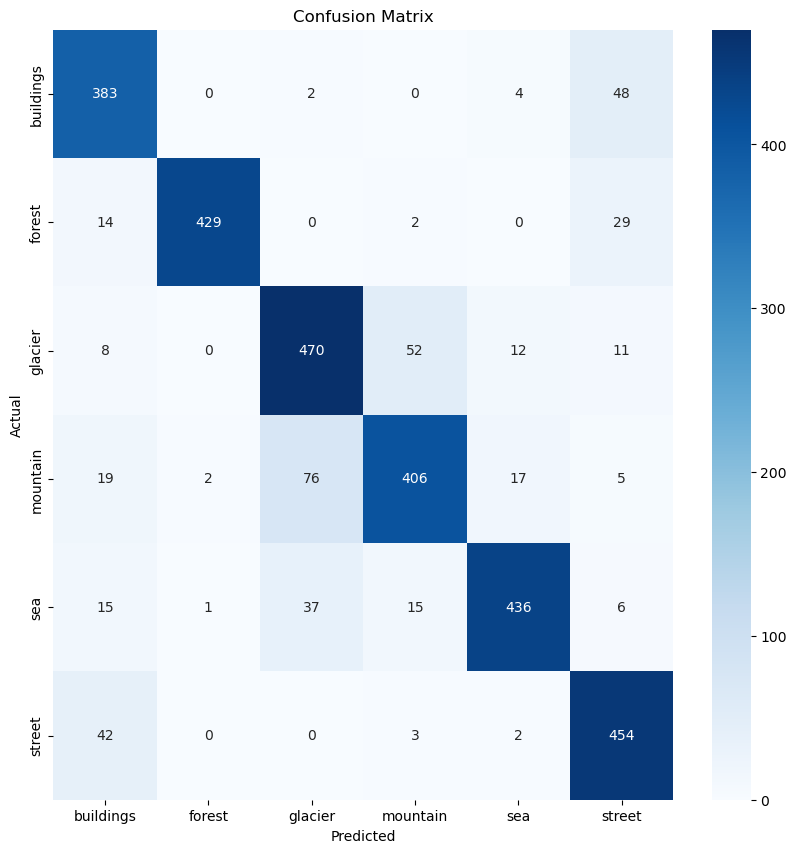

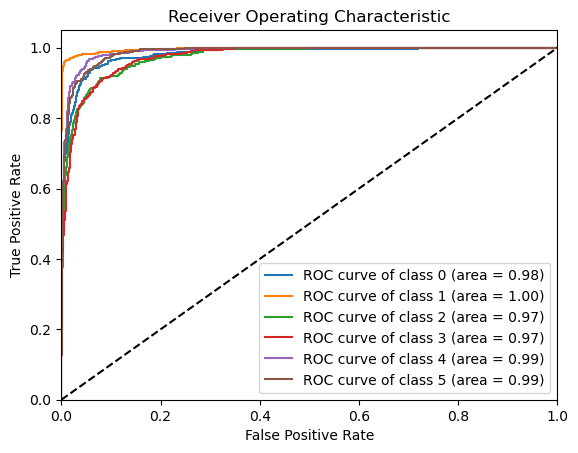

In [7]:
from sklearn.metrics import f1_score,confusion_matrix, precision_score, recall_score, accuracy_score, roc_curve, auc

predictions = model.predict(X_test)
loss, accuracy = model.evaluate(X_test, y_test_encoded)

y_pred = np.argmax(predictions, axis=1)
y_test = np.argmax(y_test_encoded, axis=1)

f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

confusion_matrix = confusion_matrix(y_test, y_pred)
print('F1 Score: ', f1)
print('Precision: ', precision)
print('Recall: ', recall)
print('Accuracy: ', accuracy)
print('Loss: ', loss)

print('Test Set Evaluation Metrics')
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=classes_names, yticklabels=classes_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 6

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_encoded[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

